# Embeddings with swissmetro 

By: Francisco C. Pereira - camara@dtu.dk, Technical University of Denmark (DTU)
July, 2019

This notebook aims to illustrate the use of Python Travel Embeddings package (PyTre) in a mode choice problem. We use the Swissmetro dataset (https://biogeme.epfl.ch/examples_swissmetro.html) as well as PyLogit (https://github.com/timothyb0912/pylogit).

Besides installing PyTre and Pylogit, you need to have keras installed as well as the typical Scipy suite. 

This code was designed for (and is therfore a companion to) the working paper _"Re-representing travel behavior through embeddings", Francisco C. Pereira_ and therefore contains the respective parameters, thresholds or whatever particular choices were made and explained there. Of course, feel free to change whatever.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pickle
import scipy.spatial
import matplotlib.cm as cm
import scipy.stats
import tensorflow as tf
import keras

import math
from collections import OrderedDict 


from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM
from keras.layers import BatchNormalization, Input, concatenate
import tempfile
import keras.models
from keras.models import Model, Sequential, load_model
from keras import regularizers
from keras.callbacks import ModelCheckpoint
import keras.backend as K

from sklearn.linear_model  import LogisticRegressionCV, LogisticRegression
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, MDS
from sklearn.model_selection import train_test_split


import pylogit as pl                   # For MNL model estimation and
                        
import PyTre

Using TensorFlow backend.


We will follow a 2-way validation method, where we split the dataset into two parts: training and test set. Let's set the proportion of training set

**note: as you will notice, the quality of embeddings will be strongly dependent on dataset size, so we use a relatively high proportion (75%)**

In [2]:
SPLIT_EMBEDDINGS_DCM=.80
TRAINSET_WITHOUT_DEV=.75

Make sure you have the swissmetro.dat file. We use the swissmetro_rand.dat, because we shuffle the original dataset (check "swissmetro_data_prep.ipynb" file)

In [3]:
sw_df_full=pd.read_csv('swissmetro_rand.dat')#,sep='\t')

There is some repeated warnings (e.g. should use .loc instead of a replace pandas function doesn't seem to be deprecated). If you're using a much later Python version (after July 2019), we recommend to comment the code below and run the whole notebook to check if there are important warnings.

In [4]:
import warnings
warnings.filterwarnings('ignore')

----------

## Some data preparation

Let's extract the corresponding part of the database (determined by SPLIT_EMBEDDINGS_DCM). We are **not** shuffling just to make the results consistent. Notice that we have already shuffled it in the data preparation file.

In [5]:
sw_df,_=train_test_split(sw_df_full, train_size=SPLIT_EMBEDDINGS_DCM, shuffle=False)

The code below serves only for readability later on. We replace each categorical value (typically a number 0-N) with its description string. 

In [6]:
tickets={0: 'None', 1: '2 way w 1/2 price', 2: '1 way w 1/2 price', 3: '2 way normal price', 4: '1 way normal price', 5: 'Half day', 6: 'Annual ticket', 7: 'Annual ticket Junior or Senior', 8: 'Free travel after 7pm', 9: 'Group ticket', 10: 'Other'}
ages={1: 'age≤24', 2: '24<age≤39', 3: '39<age≤54', 4: '54<age≤ 65', 5: '65 <age', 6: 'not known'}
incomes={0:'under 50', 1: 'under 50', 2: 'between 50 and 100', 3: 'over 100', 4: 'unknown'}
whos={0: 'unknown', 1: 'self', 2: 'employer', 3: 'half-half'}
cantons={1:'ZH', 2: 'BE', 3: 'LU', 4:'UR', 5:'SZ', 6:'OW', 7:'NW', 8:'GL', 9:'ZG', 10: 'FR', 11: 'SO', 12:'BS', 13:'BL', 
         14:'SH', 15: 'AR', 16:'AI', 17:'SG', 18:'GR', 19:'AG', 20: 'TH', 21: 'TI', 22:'VD', 23:'VS', 24: 'NE', 25:'GE', 26:'JU'}


def update_table_codes(dic, df, column):
    for t in dic:
        df[column]=df[column].replace(t, dic[t])
    return df
    
sw_df=update_table_codes(tickets, sw_df, 'TICKET')
sw_df=update_table_codes(ages, sw_df, 'AGE')
sw_df=update_table_codes(incomes, sw_df, 'INCOME')
se_df=update_table_codes(whos, sw_df, 'WHO')
    

The dataset comes with origin and destination separate in different columns, and we want to use OD as a variable, so we need pair them up

In [7]:
#combines a list of variables into a single one where its content is the concatenation of values in the list
#In our OD case, we combine ['ORIGIN', 'DEST'] into "OD", where "OD" becomes values like GE_ZH, BE_LU...
#ONLY for categorical variables
def pair_up(df, pair_name, varlist, enforce_int=False): 
    new_df=df[:]
    new_var=[]
    for index, row in new_df.iterrows():
        nv=""
        for v in varlist:
            val=row[v]
            if enforce_int:
                val=int(val)
            #nv+=str(val)+"_"
            nv+=cantons[val]+"_"
        nv=nv[:-1]
        new_var.append(nv)
    new_df[pair_name]=new_var
    
    return new_df

In [8]:
sw_df=pair_up(sw_df, "OD", ['ORIGIN', 'DEST'])

## Creation of the embeddings

Let's do our embeddings then. 

First, we need to decide which variables we want to create embeddings for

In [9]:
emb_vars=['OD', 'TICKET', 'WHO', 'AGE', 'INCOME']
#emb_vars=[ 'TICKET', 'WHO', 'AGE', 'INCOME']


Second, we need to decide, for EACH embeddings variable (emb_var), what embeddings size will be used

**note: we actually can skip this step, and just let PyTre determine the embeddings size for us. In fact, that's what we will do below. Internally, it will apply PCA to each variable and select the number of eigenvectors with a certain variance explained (varexp, default 90%)**

In [10]:
EMB_SIZES=[62,5,2,3,2]

Ah, also important: which exogenous variables do you want to give the embeddings model to estimate with. Ideally, you should use the exact same variables you will later use in your model

In [11]:
ex_vars=['CAR_TT', 'TRAIN_TT', 'SM_TT', 'FIRST', 'SURVEY']


Of course, you need to specify the target variable for the embeddings. Since we're making embeddings for mode, we use the variable "CHOICE" in Swissmetro

In [12]:
y_var=['CHOICE']

Let's create PyTre object...

In [13]:
pt=PyTre.EmbeddingsModel()

In [14]:
sw_df_train,_=train_test_split(sw_df, train_size=TRAINSET_WITHOUT_DEV, shuffle=False)

Let's finally estimate the embeddings. Feel free to play with the parameters to see their effect. Some explanations:
- we give the dataset in different components (x= columns related to the emb_vars; y=target variable;  exogenous=columns related to exogenous variables)
- it may be convenient to send labels (xlabels), just to be able to understand the output better later on
- The EPOCHS variable determines the MAXIMUM number of epochs. Your algorithm might terminate earlier if the stopping condition (not improving for more than 20 epochs). 
- This automatic termination ONLY works if you have a bit of a validation dataset (we use 20% of VALIDATION_SPLIT). If you have it as 0, then it will run EXACTLY the number of EPOCHS you selected
- The variable CRC (default TRUE) adds the regularizer layer (check paper)
- The parameter EMB_SIZE sets the embeddings size for each of the variables. The default is "auto", which automatically determines the numbers through PCA

In [15]:
m, embs=pt.fit(sw_df_train[emb_vars], sw_df_train[y_var], sw_df_train[ex_vars], xlabels=emb_vars, EPOCHS=80, VALIDATION_SPLIT=0.0, verbose=1)#, EMB_SIZE=EMB_SIZES)

Automatic determination of embedding size (PCA, varexp=0.900000) OD -> 62 (reduction from 108.000000)
Automatic determination of embedding size (PCA, varexp=0.900000) TICKET -> 5 (reduction from 9.000000)
Automatic determination of embedding size (PCA, varexp=0.900000) WHO -> 2 (reduction from 4.000000)
Automatic determination of embedding size (PCA, varexp=0.900000) AGE -> 3 (reduction from 5.000000)
Automatic determination of embedding size (PCA, varexp=0.900000) INCOME -> 2 (reduction from 4.000000)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/80
6414/6414 [==============================] - 2s 303us/step - loss: 24.4404 - output_layer_loss: 9.9811 - crc_embeddings_OD_loss: 4.5829 - crc_embeddings_TICKET_loss: 2.1459 - crc_embeddings_WHO_loss: 1.3447 - crc_embeddings_AGE_loss: 1.5601 - crc

6414/6414 [==============================] - 1s 105us/step - loss: 7.5964 - output_layer_loss: 0.7846 - crc_embeddings_OD_loss: 3.1851 - crc_embeddings_TICKET_loss: 0.6153 - crc_embeddings_WHO_loss: 0.4037 - crc_embeddings_AGE_loss: 0.5396 - crc_embeddings_INCOME_loss: 0.4964
Epoch 25/80
6414/6414 [==============================] - 1s 107us/step - loss: 7.5559 - output_layer_loss: 0.7804 - crc_embeddings_OD_loss: 3.1842 - crc_embeddings_TICKET_loss: 0.6029 - crc_embeddings_WHO_loss: 0.3964 - crc_embeddings_AGE_loss: 0.5306 - crc_embeddings_INCOME_loss: 0.4952
Epoch 26/80
6414/6414 [==============================] - 1s 108us/step - loss: 7.5160 - output_layer_loss: 0.7732 - crc_embeddings_OD_loss: 3.1708 - crc_embeddings_TICKET_loss: 0.5998 - crc_embeddings_WHO_loss: 0.3918 - crc_embeddings_AGE_loss: 0.5151 - crc_embeddings_INCOME_loss: 0.4877
Epoch 27/80
6414/6414 [==============================] - 1s 105us/step - loss: 7.4773 - output_layer_loss: 0.7720 - crc_embeddings_OD_loss: 3.166

6414/6414 [==============================] - 1s 107us/step - loss: 7.1515 - output_layer_loss: 0.7584 - crc_embeddings_OD_loss: 3.1304 - crc_embeddings_TICKET_loss: 0.5178 - crc_embeddings_WHO_loss: 0.3159 - crc_embeddings_AGE_loss: 0.4032 - crc_embeddings_INCOME_loss: 0.4351
Epoch 53/80
6414/6414 [==============================] - 1s 107us/step - loss: 7.1268 - output_layer_loss: 0.7544 - crc_embeddings_OD_loss: 3.1281 - crc_embeddings_TICKET_loss: 0.5096 - crc_embeddings_WHO_loss: 0.3204 - crc_embeddings_AGE_loss: 0.3958 - crc_embeddings_INCOME_loss: 0.4226
Epoch 54/80
6414/6414 [==============================] - 1s 108us/step - loss: 7.1402 - output_layer_loss: 0.7589 - crc_embeddings_OD_loss: 3.1296 - crc_embeddings_TICKET_loss: 0.5089 - crc_embeddings_WHO_loss: 0.3224 - crc_embeddings_AGE_loss: 0.3997 - crc_embeddings_INCOME_loss: 0.4307
Epoch 55/80
6414/6414 [==============================] - 1s 108us/step - loss: 7.1354 - output_layer_loss: 0.7593 - crc_embeddings_OD_loss: 3.133

6414/6414 [==============================] - 1s 106us/step - loss: 7.0995 - output_layer_loss: 0.7531 - crc_embeddings_OD_loss: 3.1465 - crc_embeddings_TICKET_loss: 0.5065 - crc_embeddings_WHO_loss: 0.3138 - crc_embeddings_AGE_loss: 0.3902 - crc_embeddings_INCOME_loss: 0.4248


The typical loss plot

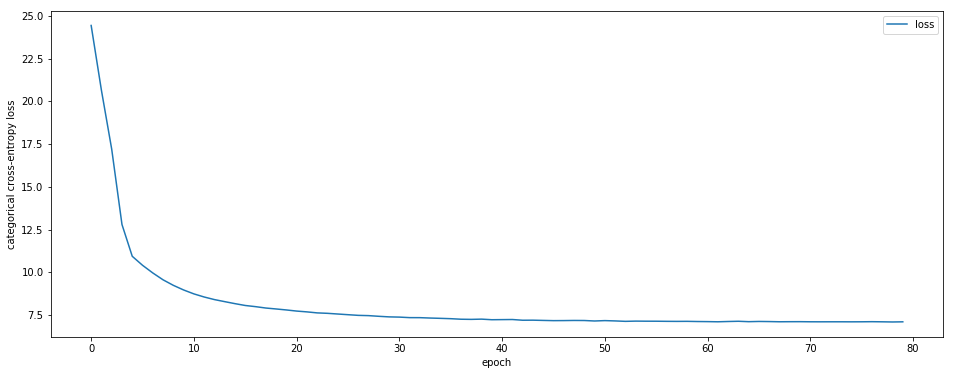

In [16]:
plt.figure(figsize=(16,6))
plt.plot(pt.model.history.history['loss'])
#plt.plot(pt.model.history.history['val_loss'])
plt.legend(['loss'])#, 'val loss'])
plt.xlabel("epoch")
plt.ylabel("categorical cross-entropy loss")
plt.show()

And now the MDS visualizations of the embeddings (see paper)

**note: as the paper mentions, the axes do not mean anything in particular. More importantly, each time we run this, we may get different rotations (but the distances remain).**

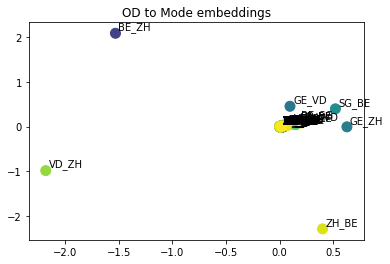

In [17]:
pt.visualize_embeddings(pt.embeddings_dic['OD']['embeddings'], pt.embeddings_dic['OD']['index2alfa_from'], adjust=False, fromlabel='OD', tolabel="Mode")


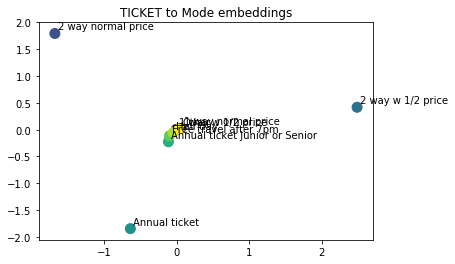

In [18]:
pt.visualize_embeddings(pt.embeddings_dic['TICKET']['embeddings'], pt.embeddings_dic['TICKET']['index2alfa_from'], adjust=False, fromlabel='TICKET', tolabel="Mode")

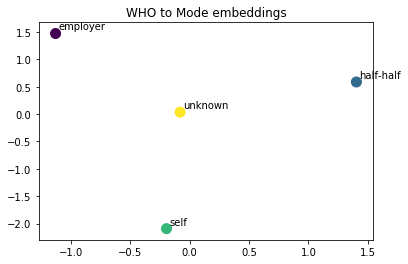

In [19]:
pt.visualize_embeddings(pt.embeddings_dic['WHO']['embeddings'], pt.embeddings_dic['WHO']['index2alfa_from'], adjust=False, fromlabel='WHO', tolabel="Mode")


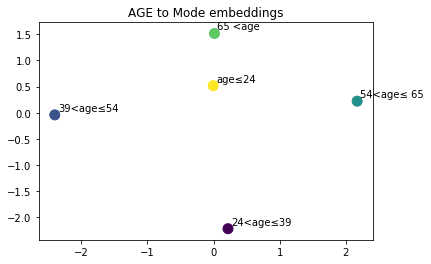

In [20]:

pt.visualize_embeddings(pt.embeddings_dic['AGE']['embeddings'], pt.embeddings_dic['AGE']['index2alfa_from'], adjust=False, fromlabel='AGE', tolabel="Mode")


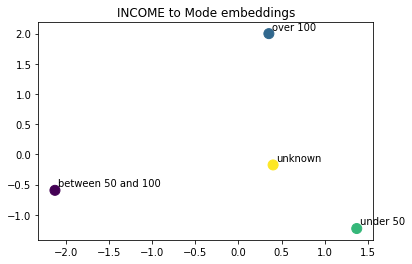

In [21]:
pt.visualize_embeddings(pt.embeddings_dic['INCOME']['embeddings'], pt.embeddings_dic['INCOME']['index2alfa_from'], adjust=False, fromlabel='INCOME', tolabel="Mode")

It is often useful to plot the distance distribution for an embeddings matrix. If this distribution is concentrated around the same value (i.e. all categories fall in roughly the same distance from each other), then an embeddings encoding will not add much value in comparison with dummies.

A particular case is when there is high concentration around zero. This means that at least some of the categories can just be grouped together into a single one (e.g. a single dummy variable).

In [22]:
def plot_distance_histogram(embs, bins=None):
        if embs in pt.embeddings_dic.keys():
            embs=pt.embeddings_dic[embs]['embeddings']
            
        distances=[]
        
        for e1 in embs:
            for e2 in embs:
                if (e1==e2).all():
                    continue
                distances.append(np.linalg.norm(e1-e2))
                
        if bins!=None:
            plt.hist(distances, bins)
        else:
            plt.hist(distances)
        plt.show()


Let's do for the ODs

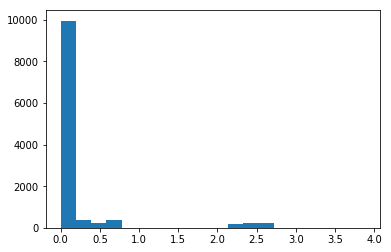

In [23]:
plot_distance_histogram('OD', 20)

As mentioned in the paper, the vast majority of the ODs don't really distinguish much from each other, which means that they could be grouped into one. There are, however, a few exceptions...

------------------------------------------

## Original PyLogit model estimation 

Pylogit needs data in the "Long format", so let's use the prepared file (to see how it's created, check swissmetro_data_prep paper.ipynb)

In [24]:
long_swiss_metro_full=pd.read_csv("long_swissmetro_rand.dat")


In [25]:
long_swiss_metro=pair_up(long_swiss_metro_full, "OD", ['ORIGIN', 'DEST'], True)

Given the relatively small size of the dataset, it's not surprising that there may be OD pairs that happen to only be observed in the test set - this would later crash any of the algorithms, so we remove them

In [26]:

all_ODs=list(long_swiss_metro['OD'].unique())

remove_ODs=[od for od in all_ODs if od not in list(pt.embeddings_dic['OD']['index2alfa_from'].values())]
for r in remove_ODs:
    long_swiss_metro=long_swiss_metro[long_swiss_metro.OD!=r]

This is the list of ODs that are NOT in the training set but can be found in the test set

In [27]:
print(remove_ODs)

[]


Same treatment as before, for interpretability of the results

In [28]:
long_swiss_metro=update_table_codes(tickets, long_swiss_metro, 'TICKET')
long_swiss_metro=update_table_codes(ages, long_swiss_metro, 'AGE')
long_swiss_metro=update_table_codes(incomes, long_swiss_metro, 'INCOME')
long_swiss_metro=update_table_codes(whos, long_swiss_metro, 'WHO')

The code below comes from the PyLogit example, which is also with Swissmetro. We're essentially creating a few variables that are needed for the MNL estimation

In [29]:
# Create the list of individual specific variables
ind_variables = sw_df.columns.tolist()[:15]

# Specify the variables that vary across individuals and some or all alternatives
# The keys are the column names that will be used in the long format dataframe.
# The values are dictionaries whose key-value pairs are the alternative id and
# the column name of the corresponding column that encodes that variable for
# the given alternative. Examples below.
alt_varying_variables = {u'travel_time': dict([(1, 'TRAIN_TT'),
                                               (2, 'SM_TT'),
                                               (3, 'CAR_TT')]),
                          u'travel_cost': dict([(1, 'TRAIN_CO'),
                                                (2, 'SM_CO'),
                                                (3, 'CAR_CO')]),
                          u'headway': dict([(1, 'TRAIN_HE'),
                                            (2, 'SM_HE')]),
                          u'seat_configuration': dict([(2, "SM_SEATS")])}

# Specify the availability variables
# Note that the keys of the dictionary are the alternative id's.
# The values are the columns denoting the availability for the
# given mode in the dataset.
availability_variables = {1: 'TRAIN_AV',
                          2: 'SM_AV', 
                          3: 'CAR_AV'}

##########
# Determine the columns for: alternative ids, the observation ids and the choice
##########
# The 'custom_alt_id' is the name of a column to be created in the long-format data
# It will identify the alternative associated with each row.
custom_alt_id = "mode_id"

# Create a custom id column that ignores the fact that this is a 
# panel/repeated-observations dataset. Note the +1 ensures the id's start at one.
obs_id_column = "custom_id"
sw_df[obs_id_column] = np.arange(sw_df.shape[0],
                                            dtype=int) + 1


# Create a variable recording the choice column
choice_column = "CHOICE"

In [30]:
##########
# Create scaled variables so the estimated coefficients are of similar magnitudes
##########
# Scale the travel time column by 60 to convert raw units (minutes) to hours
long_swiss_metro["travel_time_hrs"] = long_swiss_metro["travel_time"] / 60.0

# Scale the headway column by 60 to convert raw units (minutes) to hours
long_swiss_metro["headway_hrs"] = long_swiss_metro["headway"] / 60.0

# Figure out who doesn't incur a marginal cost for the ticket
# This can be because he/she owns an annual season pass (GA == 1) 
# or because his/her employer pays for the ticket (WHO == 2).
# Note that all the other complexity in figuring out ticket costs
# have been accounted for except the GA pass (the annual season
# ticket). Make sure this dummy variable is only equal to 1 for
# the rows with the Train or Swissmetro
long_swiss_metro["free_ticket"] = (((long_swiss_metro["GA"] == 1) |
                                    (long_swiss_metro["WHO"] == 2)) &
                                   long_swiss_metro[custom_alt_id].isin([1,2])).astype(int)
# Scale the travel cost by 100 so estimated coefficients are of similar magnitude
# and acccount for ownership of a season pass
long_swiss_metro["travel_cost_hundreth"] = (long_swiss_metro["travel_cost"] *
                                            (long_swiss_metro["free_ticket"] == 0) /
                                            100.0)

##########
# Create various dummy variables to describe the choice context of a given
# invidual for each choice task.
##########
# Create a dummy variable for whether a person has a single piece of luggage
long_swiss_metro["single_luggage_piece"] = (long_swiss_metro["LUGGAGE"] == 1).astype(int)

# Create a dummy variable for whether a person has multiple pieces of luggage
long_swiss_metro["multiple_luggage_pieces"] = (long_swiss_metro["LUGGAGE"] == 3).astype(int)

# Create a dummy variable indicating that a person is NOT first class
long_swiss_metro["regular_class"] = 1 - long_swiss_metro["FIRST"]

# Create a dummy variable indicating that the survey was taken aboard a train
# Note that such passengers are a-priori imagined to be somewhat partial to train modes
long_swiss_metro["train_survey"] = 1 - long_swiss_metro["SURVEY"]


Since we will repeat multiple estimations that extend on the same original basis, we have this function will be called at the beggining of each new model specification. All these elements will be repeated in all models. 

In [31]:
def create_spec():
    # NOTE: - Specification and variable names must be ordered dictionaries.
    #       - Keys should be variables within the long format dataframe.
    #         The sole exception to this is the "intercept" key.
    #       - For the specification dictionary, the values should be lists
    #         of integers or lists of lists of integers. Within a list, 
    #         or within the inner-most list, the integers should be the 
    #         alternative ID's of the alternative whose utility specification 
    #         the explanatory variable is entering. Lists of lists denote 
    #         alternatives that will share a common coefficient for the variable
    #         in question.

    basic_specification = OrderedDict()
    basic_names = OrderedDict()

    basic_specification["intercept"] = [1, 2]
    basic_names["intercept"] = ['ASC Train',
                                'ASC Swissmetro']

    basic_specification["travel_time_hrs"] = [[1, 2,], 3]
    basic_names["travel_time_hrs"] = ['Travel Time, units:hrs (Train and Swissmetro)',
                                      'Travel Time, units:hrs (Car)']

    basic_specification["travel_cost_hundreth"] = [1, 2, 3]
    basic_names["travel_cost_hundreth"] = ['Travel Cost * (Annual Pass == 0), units: 0.01 CHF (Train)',
                                           'Travel Cost * (Annual Pass == 0), units: 0.01 CHF (Swissmetro)',
                                           'Travel Cost, units: 0.01 CHF (Car)']

    basic_specification["headway_hrs"] = [1, 2]
    basic_names["headway_hrs"] = ["Headway, units:hrs, (Train)",
                                  "Headway, units:hrs, (Swissmetro)"]

    basic_specification["seat_configuration"] = [2]
    basic_names["seat_configuration"] = ['Airline Seat Configuration, base=No (Swissmetro)']

    basic_specification["train_survey"] = [[1, 2]]
    basic_names["train_survey"] = ["Surveyed on a Train, base=No, (Train and Swissmetro)"]

    basic_specification["regular_class"] = [1]
    basic_names["regular_class"] = ["First Class == False, (Swissmetro)"]

    basic_specification["single_luggage_piece"] = [3]
    basic_names["single_luggage_piece"] = ["Number of Luggage Pieces == 1, (Car)"]

    basic_specification["multiple_luggage_pieces"] = [3]
    basic_names["multiple_luggage_pieces"] = ["Number of Luggage Pieces > 1, (Car)"]
    
    return basic_specification, basic_names


Our experiemental design expects that the training set of embeddings is the same one as all other models (it could be different, if we wanted to assume that we had a prior dataset only for embeddings/eigenvectors training, as we also do in section 5.6 of the paper ("Embeddings for efficient survey data usage"). 

In [32]:
long_swiss_metro_train,long_swiss_metro_test=train_test_split(long_swiss_metro, train_size=SPLIT_EMBEDDINGS_DCM, shuffle=False)

Notice that this time we keep a testset variable, that will be used later to validate the model


As said, we start with the simplest of the models (the original one in PyLogit package)

In [33]:
basic_specification, basic_names=create_spec()

In [34]:
long_swiss_metro_train_train,long_swiss_metro_train_train_dev=train_test_split(long_swiss_metro_train, train_size=TRAINSET_WITHOUT_DEV, shuffle=False)


In [35]:
# Estimate the multinomial logit model (MNL)
swissmetro_mnl = pl.create_choice_model(data=long_swiss_metro_train_train,
                                        alt_id_col=custom_alt_id,
                                        obs_id_col=obs_id_column,
                                        choice_col=choice_column,
                                        specification=basic_specification,
                                        model_type="MNL",
                                        names=basic_names)


deg_freedom=sum([len(b) for b in basic_specification.values()])
# Specify the initial values and method for the optimization.
swissmetro_mnl.fit_mle(np.zeros(deg_freedom))

# Look at the estimation results
swissmetro_mnl.get_statsmodels_summary()

Log-likelihood at zero: -6,642.8394
Initial Log-likelihood: -6,642.8394
Estimation Time for Point Estimation: 0.78 seconds.
Final log-likelihood: -4,659.8511


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Multinomial Logit Model Regression Results                    
===================================================================================
Dep. Variable:                      CHOICE   No. Observations:                6,410
Model:             Multinomial Logit Model   Df Residuals:                    6,396
Method:                                MLE   Df Model:                           14
Date:                     Wed, 14 Aug 2019   Pseudo R-squ.:                   0.299
Time:                             22:05:52   Pseudo R-bar-squ.:               0.296
AIC:                             9,347.702   Log-Likelihood:             -4,659.851
BIC:                             9,442.421   LL-Null:                    -6,642.839
==================================================================================================================================
                                                                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------
ASC Train                                                         -0.3410      0.157     -2.169      0.030      -0.649      -0.033
ASC Swissmetro                                                    -0.2944      0.120     -2.446      0.014      -0.530      -0.059
Travel Time, units:hrs (Train and Swissmetro)                     -0.7185      0.042    -16.918      0.000      -0.802      -0.635
Travel Time, units:hrs (Car)                                      -0.8082      0.050    -16.199      0.000      -0.906      -0.710
Travel Cost * (Annual Pass == 0), units: 0.01 CHF (Train)         -1.9087      0.101    -18.846      0.000      -2.107      -1.710
Travel Cost * (Annual Pass == 0), units: 0.01 CHF (Swissmetro)    -0.9162      0.051    -18.048      0.000      -1.016      -0.817
Travel Cost, units: 0.01 CHF (Car)                                -1.0455      0.117     -8.958      0.000      -1.274      -0.817
Headway, units:hrs, (Train)                                       -0.4320      0.066     -6.561      0.000      -0.561      -0.303
Headway, units:hrs, (Swissmetro)                                  -0.5034      0.204     -2.474      0.013      -0.902      -0.105
Airline Seat Configuration, base=No (Swissmetro)                  -0.5895      0.092     -6.389      0.000      -0.770      -0.409
Surveyed on a Train, base=No, (Train and Swissmetro)               3.0804      0.143     21.596      0.000       2.801       3.360
First Class == False, (Swissmetro)                                 0.1179      0.084      1.396      0.163      -0.048       0.283
Number of Luggage Pieces == 1, (Car)                               0.3429      0.070      4.924      0.000       0.206       0.479
Number of Luggage Pieces > 1, (Car)                                1.9152      0.318      6.025      0.000       1.292       2.538
==================================================================================================================================
"""

We will need to get statistics for the testset


In [36]:
testsetsize=len(long_swiss_metro_test)/3 #We divide by 3, because it's a long format (three rows per data point, one per choice)

#Calculation of log likelihood for the testset
long_probs=swissmetro_mnl.predict(long_swiss_metro_test)
SCORE=sum([np.log(x) for x in np.multiply(long_probs, long_swiss_metro_test['CHOICE']) if x!=0.0])

SCORE_ORIGINAL=SCORE

#calculation of the several metrics
obs_ll=swissmetro_mnl.null_log_likelihood/swissmetro_mnl.nobs #this extracts the null likelihood per observation 
rsq=1-(SCORE/(obs_ll*testsetsize)) 
adjrsq=rsq-(1-rsq)*deg_freedom/(testsetsize-deg_freedom-1)
AIC=2*deg_freedom-2*SCORE
BIC=math.log(testsetsize)*deg_freedom-2*SCORE
print("model results for ORIGINAL (%d observations, %d degrees of freedom)"%(testsetsize,deg_freedom))
print("Log likelihood (testset)=%f"%SCORE)
print("R^2 test=%f & adjusted R^2 test=%f"%(rsq, adjrsq))
print("AIC test=%f & BIC test=%f"%(AIC, BIC))    


model results for ORIGINAL (2027 observations, 14 degrees of freedom)
Log likelihood (testset)=-1504.936129
R^2 test=0.283814 & adjusted R^2 test=0.278832
AIC test=3037.872258 & BIC test=3116.477232


-------------------

## Now with embeddings in the ODs

Let us now turn to the embeddings model. The first thing to do is to encode the corresponding variables. 

In [37]:
#This function replaces all values in emb_vars columns by their embeddings representations
new_long_sw_df=pt.replace_with_embeddings(long_swiss_metro, emb_vars)

We will now create the model MNL specification for embeddings. 

We need to go over the new variable names, but first lets create their list.

In [38]:
emb_vars_long=[item for sublist in [[v for v in new_long_sw_df.columns if v.startswith(x)] for x in emb_vars] for item in sublist]

As mentioned, we start by reusing the original specification (create_spec()). And then, we associate the embeddings variables. Notice that "TICKET" only makes sense for the Train alternative. 

In [39]:
basic_specification, basic_names=create_spec()
for emb in emb_vars_long: 
    if emb.startswith("TICKET"):  #only for train
        basic_specification[emb] = [1]
        basic_names[emb] = [emb+"_Train"]
    else:
        #if emb.startswith("OD"):
        #    continue
        basic_specification[emb] = [1,2]   #for train and SM (Car is the default category)
        basic_names[emb] = [emb+"_Train", emb+"_SM"]

In [40]:
#we do standardization on the data. In practice, it won't make a huge difference
#from sklearn.preprocessing import StandardScaler
#new_long_sw_df[emb_vars_long]=StandardScaler().fit_transform(new_long_sw_df[emb_vars_long])

The usual train/test split  and model estimation

In [41]:
new_long_sw_df_train,new_long_sw_df_test=train_test_split(new_long_sw_df, train_size=SPLIT_EMBEDDINGS_DCM, shuffle=False)

In [42]:
new_long_sw_df_train_without_dev,new_long_sw_df_dev=train_test_split(new_long_sw_df_train, train_size=TRAINSET_WITHOUT_DEV, shuffle=False)


In [43]:
# Estimate the multinomial logit model (MNL)
swissmetro_mnl = pl.create_choice_model(data=new_long_sw_df_train_without_dev,
                                        alt_id_col=custom_alt_id,
                                        obs_id_col=obs_id_column,
                                        choice_col=choice_column,
                                        specification=basic_specification,
                                        model_type="MNL",
                                        names=basic_names)

deg_freedom=sum([len(b) for b in basic_specification.values()])
# Specify the initial values and method for the optimization.
swissmetro_mnl.fit_mle(np.zeros(deg_freedom))

# Look at the estimation results
swissmetro_mnl.get_statsmodels_summary()

Log-likelihood at zero: -6,642.8394
Initial Log-likelihood: -6,642.8394
Estimation Time for Point Estimation: 9.21 seconds.
Final log-likelihood: -4,198.6940


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Multinomial Logit Model Regression Results                    
===================================================================================
Dep. Variable:                      CHOICE   No. Observations:                6,410
Model:             Multinomial Logit Model   Df Residuals:                    6,253
Method:                                MLE   Df Model:                          157
Date:                     Wed, 14 Aug 2019   Pseudo R-squ.:                   0.368
Time:                             22:06:11   Pseudo R-bar-squ.:               0.344
AIC:                             8,711.388   Log-Likelihood:             -4,198.694
BIC:                             9,773.589   LL-Null:                    -6,642.839
==================================================================================================================================
                                                                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------
ASC Train                                                         -0.8413      0.450     -1.869      0.062      -1.724       0.041
ASC Swissmetro                                                    -1.2019      0.250     -4.807      0.000      -1.692      -0.712
Travel Time, units:hrs (Train and Swissmetro)                     -0.7832      0.065    -12.093      0.000      -0.910      -0.656
Travel Time, units:hrs (Car)                                      -1.1262      0.063    -17.847      0.000      -1.250      -1.003
Travel Cost * (Annual Pass == 0), units: 0.01 CHF (Train)         -1.7181      0.151    -11.368      0.000      -2.014      -1.422
Travel Cost * (Annual Pass == 0), units: 0.01 CHF (Swissmetro)    -1.1117      0.059    -18.872      0.000      -1.227      -0.996
Travel Cost, units: 0.01 CHF (Car)                                -1.4452      0.143    -10.092      0.000      -1.726      -1.165
Headway, units:hrs, (Train)                                       -0.5235      0.073     -7.145      0.000      -0.667      -0.380
Headway, units:hrs, (Swissmetro)                                  -0.6819      0.213     -3.203      0.001      -1.099      -0.265
Airline Seat Configuration, base=No (Swissmetro)                  -0.5068      0.102     -4.960      0.000      -0.707      -0.307
Surveyed on a Train, base=No, (Train and Swissmetro)               2.8497      0.154     18.523      0.000       2.548       3.151
First Class == False, (Swissmetro)                                -0.0561      0.114     -0.491      0.624      -0.280       0.168
Number of Luggage Pieces == 1, (Car)                               0.3579      0.076      4.690      0.000       0.208       0.507
Number of Luggage Pieces > 1, (Car)                                1.5056      0.402      3.749      0.000       0.719       2.293
OD0_Train                                                         24.2968    395.095      0.061      0.951    -750.074     798.668
OD0_SM                                                           201.9303    249.389      0.810      0.418    -286.864     690.725
OD1_Train                                                         65.7644    768.811      0.086      0.932   -1441.077    1572.606
OD1_SM                                                            27.7291    567.016      0.049      0.961   -1083.602    1139.060
OD2_Train                                                        -35.9816    375.453     -0.096      0.924    -771.856     699.892
OD2_SM                                                           -42.1327    176.066     -0.239      0.811    -387.216     302.951
OD3_Train                                                        -55.3061    709.262     -0.078      0.938   -1445.434    1334.822
OD3_SM                                              

In [44]:
testsetsize=len(new_long_sw_df_test)/3 #We divide by 3, because it's a long format (three rows per data point, one per choice)

#Calculation of log likelihood for the testset
long_probs=swissmetro_mnl.predict(new_long_sw_df_test)
SCORE=sum([np.log(x) for x in np.multiply(long_probs, new_long_sw_df_test['CHOICE']) if x!=0.0])

SCORE_EMBEDDINGS=SCORE

#calculation of the several metrics
obs_ll=swissmetro_mnl.null_log_likelihood/swissmetro_mnl.nobs #this extracts the null likelihood per observation 
rsq=1-(SCORE/(obs_ll*testsetsize)) 
adjrsq=rsq-(1-rsq)*deg_freedom/(testsetsize-deg_freedom-1)
AIC=2*deg_freedom-2*SCORE
BIC=math.log(testsetsize)*deg_freedom-2*SCORE
print("model results for EMBEDDINGS (%d observations, %d degrees of freedom)"%(testsetsize,deg_freedom))
print("Log likelihood (testset)=%f"%SCORE)
print("R^2 test=%f & adjusted R^2 test=%f"%(rsq, adjrsq))
print("AIC test=%f & BIC test=%f"%(AIC, BIC))    


model results for EMBEDDINGS (2027 observations, 157 degrees of freedom)
Log likelihood (testset)=-1387.818266
R^2 test=0.339549 & adjusted R^2 test=0.284090
AIC test=3089.636533 & BIC test=3971.135167


In [45]:
print("variable name\tcoeff\tstderr\tz-score\tp-value")

count=0
countsig=0
for var in ['OD', 'WHO', 'TICKET', 'INCOME', 'AGE']:#emb_vars:#[d for d in emb_vars if d!='OD']:

    alfs=pt.embeddings_dic[var]['index2alfa_from']
    embs=pt.embeddings_dic[var]['embeddings']

    alternatives=['Train', 'SM']
    if var in ["TICKET"]:#, "OD"]:
        alternatives=['Train']
    for m in alternatives:
        for i in range(embs.shape[0]):
            mean=0
            stde=0
            mean_default=0
            stde_default=0
            for j in range(embs.shape[1]):
                mean+=embs[i,j]*swissmetro_mnl.coefs[var+str(j)+"_"+m]
                stde+=embs[i,j]**2*swissmetro_mnl.standard_errors[var+str(j)+"_"+m]**2
            if i==0:
                stde_default=stde
                mean_default=mean
                continue
            stde=math.sqrt(stde+stde_default)
            z_score=(mean-mean_default)/stde        
            p_value = scipy.stats.norm.sf(abs(z_score))*2 #twosided
            signif=""
            if p_value<0.05:
                signif="**"
                countsig+=1
            elif p_value<0.1:
                signif="*"
                countsig+=1
            #print(var+str(i)+"_"+m+"\t%.3f\t%.3f\t%.3f\t%.3f%s"% (mean, stde, z_score, p_value, signif))
            #print(alfs[i]+"_"+m+"\t%.3f\t%.3f\t%.3f\t%.3f%s"% (mean, stde, z_score, p_value, signif))
            if signif!="" or var!="OD":
                print(var+"_"+alfs[i]+"_"+m+"&%.3f&%.3f&%.3f&%.3f%s\\\\"% (mean, stde, z_score, p_value, signif))
            count+=1



        
            

variable name	coeff	stderr	z-score	p-value
WHO_half-half_Train&-0.187&0.131&-1.435&0.151\\
WHO_self_Train&0.236&0.143&1.649&0.099*\\
WHO_unknown_Train&-0.026&0.015&-1.724&0.085*\\
WHO_half-half_SM&0.080&0.080&0.993&0.321\\
WHO_self_SM&-0.199&0.087&-2.277&0.023**\\
WHO_unknown_SM&0.014&0.009&1.523&0.128\\
TICKET_1 way w 1/2 price_Train&-0.962&1.598&-0.602&0.547\\
TICKET_2 way normal price_Train&-1.436&68.387&-0.021&0.983\\
TICKET_2 way w 1/2 price_Train&-1.330&101.168&-0.013&0.990\\
TICKET_Annual ticket_Train&-0.004&54.070&-0.000&1.000\\
TICKET_Annual ticket Junior or Senior_Train&-0.182&6.027&-0.030&0.976\\
TICKET_Free travel after 7pm_Train&0.287&4.109&0.070&0.944\\
TICKET_Half day_Train&-0.963&2.723&-0.354&0.724\\
TICKET_Other_Train&-0.209&1.302&-0.161&0.872\\
INCOME_over 100_Train&-0.048&0.084&-0.575&0.565\\
INCOME_under 50_Train&0.229&0.091&2.523&0.012**\\
INCOME_unknown_Train&0.066&0.024&2.692&0.007**\\
INCOME_over 100_SM&0.186&0.051&3.684&0.000**\\
INCOME_under 50_SM&-0.192&0.066

-----------------

## Now with dummy variable model

Let's start by applying the dummy encoding into the emb_vars variables

In [46]:
dummy_long_sw_df=pd.get_dummies(long_swiss_metro, columns=emb_vars, drop_first=True)

Same as before: in order to create the specification, we need to get the list of new variables (dataframe columns) that correspond to the dummy variables

In [47]:
dummy_vars_long=[item for sublist in [[v for v in dummy_long_sw_df.columns if v.startswith(x)] for x in emb_vars] for item in sublist]

There's a new subtlety here: as explained in the paper, if we use the OD variables (as dummies), the result is catastrophic, so we include a model without those variables to keep it a decent baseline.  

In [48]:
exclude_ODs=[d for d in dummy_vars_long if not d.startswith("OD")]

In [49]:
basic_specification, basic_names=create_spec()
#for dum in dummy_vars_long: #if you want to try the model including OD variables, replace the line below with this one. 
for dum in exclude_ODs:
    if dum.startswith("TICKET"):
        basic_specification[dum] = [1]
        basic_names[dum] = [dum+"_Train"]
    else:
        basic_specification[dum] = [1,2]
        basic_names[dum] = [dum+"_Train", dum+"_SM"]

In [50]:
dummy_long_sw_df_train,dummy_long_sw_df_test=train_test_split(dummy_long_sw_df, train_size=SPLIT_EMBEDDINGS_DCM, shuffle=False)

In [51]:
dummy_long_sw_df_train_train,dummy_long_sw_df_train_dev=train_test_split(dummy_long_sw_df_train, train_size=TRAINSET_WITHOUT_DEV, shuffle=False)


In [52]:
# Estimate the multinomial logit model (MNL)
swissmetro_mnl = pl.create_choice_model(data=dummy_long_sw_df_train_train,
                                        alt_id_col=custom_alt_id,
                                        obs_id_col=obs_id_column,
                                        choice_col=choice_column,
                                        specification=basic_specification,
                                        model_type="MNL",
                                        names=basic_names)

deg_freedom=sum([len(b) for b in basic_specification.values()])
# Specify the initial values and method for the optimization.
swissmetro_mnl.fit_mle(np.zeros(deg_freedom))


# Look at the estimation results
swissmetro_mnl.get_statsmodels_summary()

Log-likelihood at zero: -6,642.8394
Initial Log-likelihood: -6,642.8394
Estimation Time for Point Estimation: 1.31 seconds.
Final log-likelihood: -4,357.8622


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Multinomial Logit Model Regression Results                    
===================================================================================
Dep. Variable:                      CHOICE   No. Observations:                6,410
Model:             Multinomial Logit Model   Df Residuals:                    6,368
Method:                                MLE   Df Model:                           42
Date:                     Wed, 14 Aug 2019   Pseudo R-squ.:                   0.344
Time:                             22:06:15   Pseudo R-bar-squ.:               0.338
AIC:                             8,799.724   Log-Likelihood:             -4,357.862
BIC:                             9,083.880   LL-Null:                    -6,642.839
==================================================================================================================================
                                                                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------
ASC Train                                                         -1.5055      0.433     -3.473      0.001      -2.355      -0.656
ASC Swissmetro                                                     0.0477      0.145      0.329      0.743      -0.237       0.332
Travel Time, units:hrs (Train and Swissmetro)                     -0.6615      0.044    -14.951      0.000      -0.748      -0.575
Travel Time, units:hrs (Car)                                      -0.8117      0.050    -16.153      0.000      -0.910      -0.713
Travel Cost * (Annual Pass == 0), units: 0.01 CHF (Train)         -1.5562      0.144    -10.794      0.000      -1.839      -1.274
Travel Cost * (Annual Pass == 0), units: 0.01 CHF (Swissmetro)    -1.0110      0.053    -19.043      0.000      -1.115      -0.907
Travel Cost, units: 0.01 CHF (Car)                                -0.9749      0.118     -8.260      0.000      -1.206      -0.744
Headway, units:hrs, (Train)                                       -0.5272      0.073     -7.259      0.000      -0.670      -0.385
Headway, units:hrs, (Swissmetro)                                  -0.5894      0.208     -2.833      0.005      -0.997      -0.182
Airline Seat Configuration, base=No (Swissmetro)                  -0.4209      0.101     -4.181      0.000      -0.618      -0.224
Surveyed on a Train, base=No, (Train and Swissmetro)               2.9376      0.145     20.254      0.000       2.653       3.222
First Class == False, (Swissmetro)                                 0.0050      0.110      0.046      0.964      -0.211       0.221
Number of Luggage Pieces == 1, (Car)                               0.3184      0.072      4.451      0.000       0.178       0.459
Number of Luggage Pieces > 1, (Car)                                1.5886      0.323      4.922      0.000       0.956       2.221
TICKET_1 way w 1/2 price_Train                                    -0.7668      0.458     -1.672      0.094      -1.665       0.132
TICKET_2 way normal price_Train                                   -0.1896      0.393     -0.482      0.630      -0.960       0.581
TICKET_2 way w 1/2 price_Train                                    -0.1492      0.378     -0.395      0.693      -0.889       0.591
TICKET_Annual ticket_Train                                         0.9699      0.385      2.519      0.012       0.215       1.724
TICKET_Annual ticket Junior or Senior_Train                        0.9957      0.411      2.421      0.015       0.189       1.802
TICKET_Free travel after 7pm_Train                                 1.4544      0.455      3.194      0.001       0.562       2.347
TICKET_Half day_Train                                              0.5669      0.438      1.295      0.195      -0.291       1.425
TICKET_Other_Train                                  

...results...

In [53]:
testsetsize=len(dummy_long_sw_df_test)/3 #We divide by 3, because it's a long format (three rows per data point, one per choice)

#Calculation of log likelihood for the testset
long_probs=swissmetro_mnl.predict(dummy_long_sw_df_test)
SCORE=sum([np.log(x) for x in np.multiply(long_probs, dummy_long_sw_df_test['CHOICE']) if x!=0.0])

SCORE_DUMMY=SCORE
#calculation of the several metrics
obs_ll=swissmetro_mnl.null_log_likelihood/swissmetro_mnl.nobs #this extracts the null likelihood per observation 
rsq=1-(SCORE/(obs_ll*testsetsize)) 
adjrsq=rsq-(1-rsq)*deg_freedom/(testsetsize-deg_freedom-1)
AIC=2*deg_freedom-2*SCORE
BIC=math.log(testsetsize)*deg_freedom-2*SCORE
print("model results for DUMMY (%d observations, %d degrees of freedom)"%(testsetsize,deg_freedom))
print("Log likelihood (testset)=%f"%SCORE)
print("R^2 test=%f & adjusted R^2 test=%f"%(rsq, adjrsq))
print("AIC test=%f & BIC test=%f"%(AIC, BIC))    


model results for DUMMY (2027 observations, 42 degrees of freedom)
Log likelihood (testset)=-1414.042459
R^2 test=0.327070 & adjusted R^2 test=0.312829
AIC test=2912.084918 & BIC test=3147.899839


-------------

## And now PCA

To generate the PCA model, we can start with the dummy variable encoding

In [54]:
dummy_long_sw_df=pd.get_dummies(long_swiss_metro, columns=emb_vars, drop_first=False)

In [55]:
dummy_vars_long=[item for sublist in [[v for v in dummy_long_sw_df.columns if v.startswith(x)] for x in emb_vars] for item in sublist]

For each variable in the emb_vars (that is now represented through dummies), obtain its respective PCA decomposition

In [56]:
base_features=[c for c in dummy_long_sw_df.columns if c not in dummy_vars_long]
pca_long_sw_df=dummy_long_sw_df[base_features][:]
pca_dic={}

for d, EMB_SIZE in zip(emb_vars, EMB_SIZES):
    dlist=[w for w in dummy_vars_long if w.startswith(d)]
    X_transformed,EMB_S, pca_dic[d]=pt.pca_embedding(dummy_long_sw_df[dlist], varexp=EMB_SIZE)
    print("Reduced %s that had dim=%d into %d"%(d, len(dlist),EMB_S))
    eigenvector=0
    for x in X_transformed.T:
        pca_long_sw_df[d+str(eigenvector)]=x
        eigenvector+=1

Reduced OD that had dim=108 into 62
Reduced TICKET that had dim=9 into 5
Reduced WHO that had dim=4 into 2
Reduced AGE that had dim=5 into 3
Reduced INCOME that had dim=4 into 2


The numbers above should match the ones from the embeddings model, otherwise, something went wrong! 

In [57]:
pca_vars_long=[item for sublist in [[v for v in pca_long_sw_df.columns if v.startswith(x)] for x in emb_vars] for item in sublist]

In [58]:
basic_specification, basic_names=create_spec()
for p in pca_vars_long:
    if p.startswith("TICKET"):
        basic_specification[p] = [1]
        basic_names[p] = [p+"_Train"]
    else:
        basic_specification[p] = [1,2]
        basic_names[p] = [p+"_Train", p+"_SM"]

In [59]:
pca_long_sw_df_train,pca_long_sw_df_test=train_test_split(pca_long_sw_df, train_size=SPLIT_EMBEDDINGS_DCM, shuffle=False)

In [60]:
pca_long_sw_df_train_train,pca_long_sw_df_train_dev=train_test_split(pca_long_sw_df_train, train_size=TRAINSET_WITHOUT_DEV, shuffle=False)


In [61]:
# Estimate the multinomial logit model (MNL)
swissmetro_mnl = pl.create_choice_model(data=pca_long_sw_df_train_train,
                                        alt_id_col=custom_alt_id,
                                        obs_id_col=obs_id_column,
                                        choice_col=choice_column,
                                        specification=basic_specification,
                                        model_type="MNL",
                                        names=basic_names)

deg_freedom=sum([len(b) for b in basic_specification.values()])
# Specify the initial values and method for the optimization.
swissmetro_mnl.fit_mle(np.zeros(deg_freedom))


# Look at the estimation results
swissmetro_mnl.get_statsmodels_summary()

Log-likelihood at zero: -6,642.8394
Initial Log-likelihood: -6,642.8394
Estimation Time for Point Estimation: 5.61 seconds.
Final log-likelihood: -4,154.3077


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Multinomial Logit Model Regression Results                    
===================================================================================
Dep. Variable:                      CHOICE   No. Observations:                6,410
Model:             Multinomial Logit Model   Df Residuals:                    6,253
Method:                                MLE   Df Model:                          157
Date:                     Wed, 14 Aug 2019   Pseudo R-squ.:                   0.375
Time:                             22:06:24   Pseudo R-bar-squ.:               0.351
AIC:                             8,622.615   Log-Likelihood:             -4,154.308
BIC:                             9,684.817   LL-Null:                    -6,642.839
==================================================================================================================================
                                                                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------
ASC Train                                                         -2.1533      0.286     -7.525      0.000      -2.714      -1.592
ASC Swissmetro                                                    -1.3569      0.206     -6.591      0.000      -1.760      -0.953
Travel Time, units:hrs (Train and Swissmetro)                     -0.7067      0.063    -11.230      0.000      -0.830      -0.583
Travel Time, units:hrs (Car)                                      -1.2218      0.065    -18.690      0.000      -1.350      -1.094
Travel Cost * (Annual Pass == 0), units: 0.01 CHF (Train)         -1.7124      0.151    -11.351      0.000      -2.008      -1.417
Travel Cost * (Annual Pass == 0), units: 0.01 CHF (Swissmetro)    -1.1314      0.060    -18.995      0.000      -1.248      -1.015
Travel Cost, units: 0.01 CHF (Car)                                -1.6350      0.148    -11.045      0.000      -1.925      -1.345
Headway, units:hrs, (Train)                                       -0.5169      0.073     -7.110      0.000      -0.659      -0.374
Headway, units:hrs, (Swissmetro)                                  -0.7125      0.213     -3.339      0.001      -1.131      -0.294
Airline Seat Configuration, base=No (Swissmetro)                  -0.4991      0.102     -4.898      0.000      -0.699      -0.299
Surveyed on a Train, base=No, (Train and Swissmetro)               2.9624      0.159     18.652      0.000       2.651       3.274
First Class == False, (Swissmetro)                                -0.0752      0.113     -0.668      0.504      -0.296       0.146
Number of Luggage Pieces == 1, (Car)                               0.3291      0.076      4.304      0.000       0.179       0.479
Number of Luggage Pieces > 1, (Car)                                1.9537      0.423      4.614      0.000       1.124       2.784
OD0_Train                                                          0.3456      0.181      1.912      0.056      -0.009       0.700
OD0_SM                                                             0.3380      0.119      2.848      0.004       0.105       0.571
OD1_Train                                                          0.1838      0.208      0.886      0.376      -0.223       0.591
OD1_SM                                                            -0.5537      0.128     -4.341      0.000      -0.804      -0.304
OD2_Train                                                          0.9527      0.226      4.212      0.000       0.509       1.396
OD2_SM                                                             0.6259      0.159      3.932      0.000       0.314       0.938
OD3_Train                                                          0.0389      0.274      0.142      0.887      -0.498       0.575
OD3_SM                                              

In [62]:
long_probs=swissmetro_mnl.predict(pca_long_sw_df_test)
SCORE=sum([np.log(x) for x in np.multiply(long_probs, pca_long_sw_df_test['CHOICE']) if x!=0.0])

print(SCORE)
SCORE_PCA=SCORE

obs_ll=swissmetro_mnl.null_log_likelihood/swissmetro_mnl.nobs
rsq=1-(SCORE/(obs_ll*testsetsize))
adjrsq=rsq-(1-rsq)*deg_freedom/(testsetsize-deg_freedom-1)
AIC=2*deg_freedom-2*SCORE
BIC=math.log(testsetsize)*deg_freedom-2*SCORE
print("model results for global PCA model")
print("R^2 test=%f & adjusted R^2 test=%f"%(rsq, adjrsq))
print("AIC test=%f & BIC test=%f"%(AIC, BIC))    


-1392.4726826927974
model results for global PCA model
R^2 test=0.337334 & adjusted R^2 test=0.281689
AIC test=3098.945365 & BIC test=3980.444000


In [63]:
print("variable name\tcoeff\tstderr\tz-score\tp-value")

count=0
countsig=0
for var, EMB_SIZE in zip(emb_vars, EMB_SIZES):#[d for d in emb_vars if d!='OD']:

    alfs=pt.embeddings_dic[var]['index2alfa_from']
    evecs=pca_dic[var].components_

    alternatives=['Train', 'SM']
    if var in ["TICKET"]:#, "OD"]:
        alternatives=['Train']
    for m in alternatives:
        for i in range(evecs.shape[0]):
            
            mean=0
            stde=0
            
            for j in range(EMB_SIZE):
                mean+=evecs[i,j]*swissmetro_mnl.coefs[var+str(j)+"_"+m]
                stde+=evecs[i,j]**2*swissmetro_mnl.standard_errors[var+str(j)+"_"+m]**2
            if i==0:
                stde_default=stde
                mean_default=mean
                continue
            stde=math.sqrt(stde+stde_default)
            z_score=(mean-mean_default)/stde                
            p_value = scipy.stats.norm.sf(abs(z_score))*2 #twosided
            signif=""
            s="%"
            if p_value<0.05:
                signif="**"
                countsig+=1
                s=""
            elif p_value<0.1:
                signif="*"
                countsig+=1
                s=""
            #print(var+str(i)+"_"+m+"\t%.3f\t%.3f\t%.3f\t%.3f%s"% (mean, stde, z_score, p_value, signif))
            #print(alfs[i]+"_"+m+"\t%.3f\t%.3f\t%.3f\t%.3f%s"% (mean, stde, z_score, p_value, signif))
            if signif!="" or var!="OD":
                print(var+"_"+alfs[i]+"_"+m+"&%.3f&%.3f&%.3f&%.3f%s&&\\\\"% (mean, stde, z_score, p_value, signif))
            count+=1



        
            

variable name	coeff	stderr	z-score	p-value
OD_TH_BE_Train&-4.453&2.892&-1.995&0.046**&&\\
OD_ZH_AR_Train&-5.718&3.012&-2.336&0.020**&&\\
OD_AG_ZH_SM&-1.642&1.276&-1.684&0.092*&&\\
OD_FR_GR_SM&-1.537&0.931&-2.195&0.028**&&\\
OD_GE_AI_SM&3.551&1.351&2.254&0.024**&&\\
OD_GE_BE_SM&-1.574&1.164&-1.786&0.074*&&\\
OD_GE_JU_SM&1.680&0.590&1.991&0.046**&&\\
OD_GE_VD_SM&-1.234&0.734&-2.371&0.018**&&\\
OD_GE_ZH_SM&-1.918&0.632&-3.835&0.000**&&\\
OD_GL_FR_SM&-1.781&0.957&-2.390&0.017**&&\\
OD_GR_GE_SM&-1.459&0.770&-2.550&0.011**&&\\
OD_GR_VD_SM&-3.459&0.962&-4.119&0.000**&&\\
OD_LU_VD_SM&-1.998&0.690&-3.630&0.000**&&\\
OD_SG_SO_SM&1.629&0.674&1.667&0.095*&&\\
OD_SG_VD_SM&-1.587&0.509&-4.112&0.000**&&\\
OD_SG_ZG_SM&-0.458&0.586&-1.645&0.100*&&\\
OD_SH_VD_SM&-1.618&1.205&-1.763&0.078*&&\\
OD_SZ_VD_SM&-0.976&0.534&-2.775&0.006**&&\\
OD_TH_VD_SM&-1.878&0.887&-2.687&0.007**&&\\
OD_TH_VS_SM&-0.766&0.727&-1.749&0.080*&&\\
OD_TH_ZH_SM&-0.310&0.418&-1.950&0.051*&&\\
OD_VD_BS_SM&-1.308&0.850&-2.133&0.033**&

A summary of the results (only showing test likelihoods)

In [64]:
print("SCORE ORIGINAL=%d\n SCORE EMBEDDINGS=%d\n SCORE DUMMY=%d\n SCORE PCA=%d\n"%(SCORE_ORIGINAL, SCORE_EMBEDDINGS, SCORE_DUMMY, SCORE_PCA))

SCORE ORIGINAL=-1504
 SCORE EMBEDDINGS=-1387
 SCORE DUMMY=-1414
 SCORE PCA=-1392

